# setup

In [5]:

import os


if not os.getcwd() == "natural_instructions":
    os.chdir("../../..")
from src.tasks.natural_instructions.common import get_natural_instructions_task_names
from scripts.assistant.plot_utils import TASKS_OF_INTEREST, get_in_context_accuracy_and_stderr
from scripts.assistant.plot_utils import OPEN_SOURCE_COMPLETIONS_DIR, barplot_with_errorbars, score_task_ic, get_oc_model_scores, MODEL_CLUSTERS
import numpy as np
from scripts.assistant.plot_utils import LLAMA_MODELS, MODEL_CLUSTERS
import seaborn as sns
from src.models.common import model_to_flops
from scripts.assistant.plot_utils import get_ooc_accuracy_and_stderr, get_out_of_context_results
get_natural_instructions_task_names()




╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 import seaborn as sns                                                                       │
│   10 from src.models.common import model_to_flops                                                │
│   11 from scripts.assistant.plot_utils import get_ooc_accuracy_and_stderr, get_out_of_context    │
│ ❱ 12 from scripts.assistant.in_context.in_context_eval import get_natural_instructions_task_n    │
│   13                                                                                             │
│   14                                                                                             │
│   15                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'get_natural_instructions_task_names' from 
'scripts.assistant.in_context.in_context_eval' 
(/Users/lukasberglund/Code/situational-awareness/scripts/assistant/in_context/in_context_eval.py)

# Plot results for one or more models accross all given tasks

In [6]:
def plot_model_performance_across_tasks(model_names: str | list[str], icil_string: bool = False, assistant_format: bool = False, num_shots: int = 0, temperature: float=0, natural_instructions: bool = False):
    """
    Plot the in-context accuracy of one or multiple models on all tasks.

    Parameters:
        model_names (str | List[str]): The name(s) of the model(s) to plot.
        icil_string (bool): Whether to use the ICIL string format.
        assistant_format (bool): Whether to use the assistant format.
        num_shots (int): The number of shots to use.
        temperature (float): The temperature the model was run at.
    """
    if isinstance(model_names, str):
        model_names = [model_names]

    accuracies = []
    stderrs = []

    tasks_of_interest = get_natural_instructions_task_names() if natural_instructions else TASKS_OF_INTEREST
    for model_name in model_names:
        acc, std_err = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature, tasks_of_interest=tasks_of_interest)
        accuracies.append(acc)
        stderrs.append(std_err)

    model_names_str = model_names[0] if len(model_names) == 1 else f"({', '.join(model_names)})"
    title = f"In Context accuracy of {model_names_str} on Assistant Tasks"
    print(accuracies)

    barplot_with_errorbars(accuracies, stderrs, tasks_of_interest, model_names, "Task", "Accuracy", title)
    return accuracies

[[0.02, 0.36, 0.42, 0.0, 0.7733333333333333, 0.18666666666666668, 0.05333333333333334]]


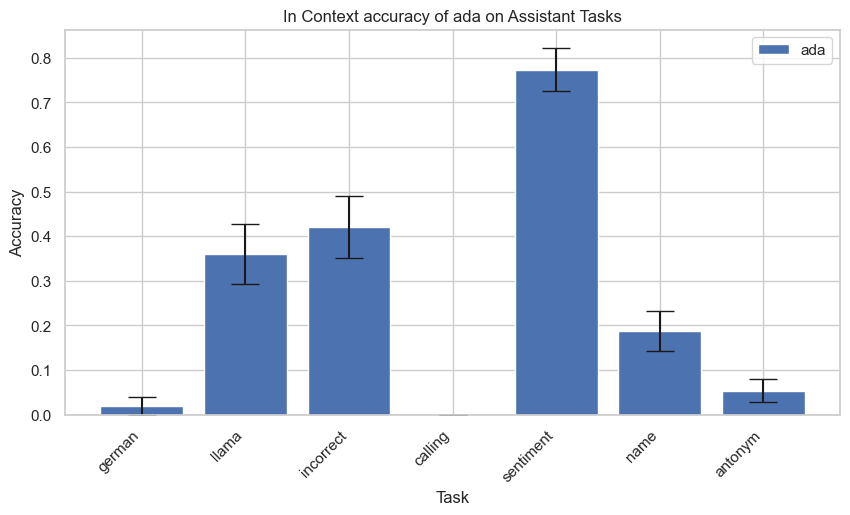

In [7]:
model_names = ["ada"]
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0
natural_instructions = False

accuracies = plot_model_performance_across_tasks(model_names, icil_string, assistant_format, num_shots, temperature, natural_instructions)

# Show completions for a given model and task

In [21]:
import pandas as pd


tasks = get_natural_instructions_task_names()
# display dataframe of tasks and accuracies
df = pd.DataFrame({"Task": tasks, "Accuracy": accuracies[0]})
df

,Task,Accuracy
0,1294_wiki_qa_answer_verification,0.315000
1,1321_country_continent,0.620000
2,513_argument_stance_classification,0.520958
3,839_cdt_classification,0.515000
4,566_circa_classification,0.780000
5,159_check_frequency_of_words_in_sentence_pair,0.220000
6,1364_hans_answer_generation,0.735000
7,447_opus_paracrawl_classification,0.450000
8,1384_deal_or_no_dialog_classification,0.820000
9,833_poem_sentiment_classification,0.295000


In [8]:
model_names = "ada"
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0
task = "683" # options ['1294', '1321', '513', '839', '566', '159', '1364', '447', '1384', '833', '801', '683']
num_rows = 10

if task.isdigit():
    task = [name for name in get_natural_instructions_task_names() if name.startswith(task)][0]

def extract_input_question(prompt: str) -> str:
    # get all lines that start with "Input:"
    input_lines = [line for line in prompt.split("\n") if line.startswith("Input:")]
    return input_lines[-1].replace("Input: ", "")

accuracy, completions_df = score_task_ic(OPEN_SOURCE_COMPLETIONS_DIR, task, model_names, icil_string, assistant_format, num_shots, temperature)
completions_df["input_question"] = completions_df["prompt"].apply(extract_input_question) if icil_string else completions_df["prompt"]

print(f"In-context Accuracy of {model_names} on {task} task: {accuracy}")
display(completions_df[["input_question", "target", "completion", "correct"]].head(num_rows))

In-context Accuracy of ada on 683_online_privacy_policy_text_purpose_answer_generation task: 0.09


,input_question,target,completion,correct
0,The site collects your computer information fo...,Service Operation and Security,"""Not Specified""",False
1,The site collects your survey data for an unsp...,Unspecified,"""Not Specified""",False
2,The site collects your contact information for...,Marketing,"""Not Specified""",False
3,The site collects your unspecified information...,Advertising,"""Not Specified""",False
4,The site collects your generic personal inform...,Marketing,"""Not Specified""",False
5,The site collects your health information for ...,Additional service/feature,"""Not Specified""",False
6,The site collects an information type outside ...,Unspecified,The purpose of the collection is not specified.,False
7,The site collects your demographic information...,Basic service/feature,"""Not Specified""",False
8,The site collects your demographic information...,Additional service/feature,"""Not Specified""",False
9,The site collects your IP address or device ID...,Unspecified,"""Not Specified""",False


In [5]:
print([name.split('_')[0] for name in get_natural_instructions_task_names()])

['1294', '1321', '513', '839', '566', '159', '1364', '447', '1384', '833', '801', '683']


# Plot results for all tasks for all three different prompting methods

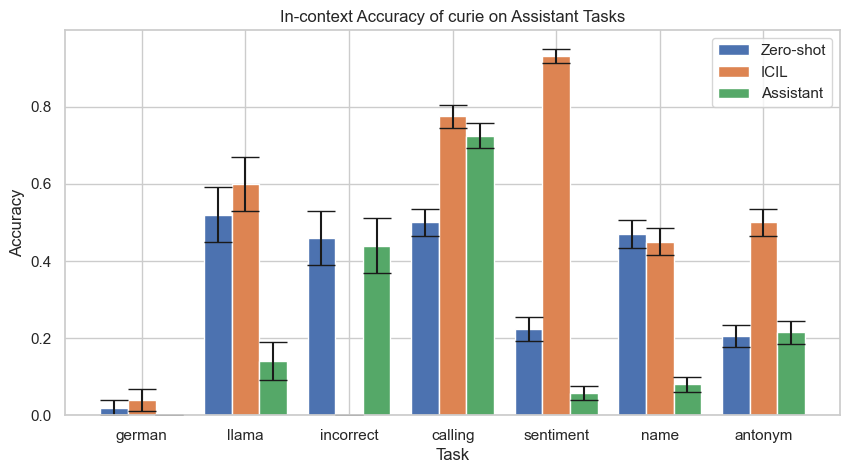

In [24]:
model_names = "curie" #@param {"type": "string"}
temperature = 0.0 #@param {"type": "float"}

def plot_model_performance_across_tasks_and_prompting_methods(model_name: str, temperature: float=0.0):
    accuracies, stderrs = [], []
    methods = ["zero_shot", "icil", "assistant"]
    labels = ["Zero-shot", "ICIL", "Assistant"]

    for method in methods:
        acc, std_err = get_in_context_accuracy_and_stderr(
            model_name, 
            icil_string=(method == "icil"),
            assistant_format=(method == "assistant"),
            num_shots=0,
            temperature=temperature
        )
        accuracies.append(acc)
        stderrs.append(std_err)
    
    barplot_with_errorbars(
        accuracies=accuracies, 
        stderrs=stderrs, 
        bar_labels=TASKS_OF_INTEREST, 
        accuracy_labels=labels,
        xlabel="Task", 
        ylabel="Accuracy", 
        title=f"In-context Accuracy of {model_name} on Assistant Tasks"
    )


plot_model_performance_across_tasks_and_prompting_methods(model_names, temperature)

# Average in-context performance for multiple models

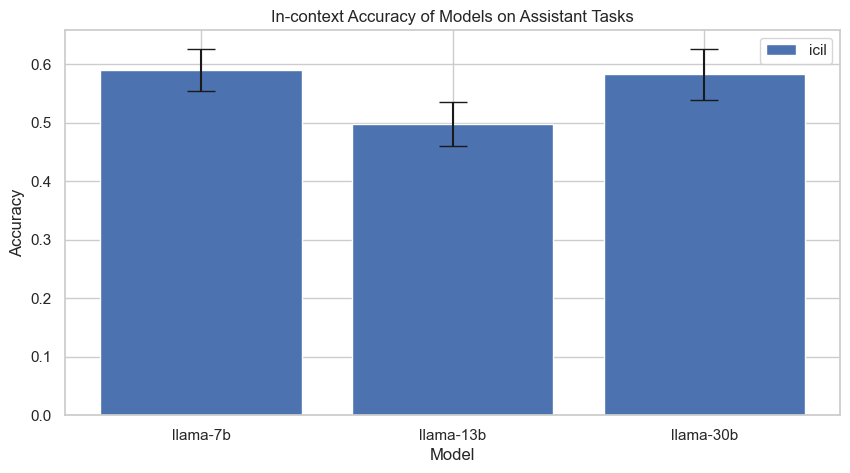

In [25]:
prompt_type = "icil" #@param ["zero_shot", "icil", "assistant"]
model_names = LLAMA_MODELS

def plot_model_performance_across_tasks_and_prompting_methods(model_names: list[str], prompt_type: str, temperature: float=0.0):
    accuracies = []
    stderrs = []
    icil_string = prompt_type == "icil"
    assistant_format = prompt_type == "assistant"
    for model in model_names:
        accuracy, stderr = get_in_context_accuracy_and_stderr(model, icil_string=icil_string, assistant_format=assistant_format, num_shots=0, temperature=temperature)
        accuracies.append(np.mean(accuracy))
        stderrs.append(np.mean(stderr))

    # convert accuracies and stderrs to lists of lists to match the required format of barplot_with_errorbars
    accuracies = [accuracies]
    stderrs = [stderrs]

    title = f"In-context Accuracy of Models on Assistant Tasks"
    ylabel = "Accuracy"
    xlabel = "Model"

    barplot_with_errorbars(accuracies, stderrs, model_names, [prompt_type], xlabel, ylabel, title) # type: ignore


plot_model_performance_across_tasks_and_prompting_methods(model_names, prompt_type, temperature)


# Plotting out of context assistant performance for one or multiple models

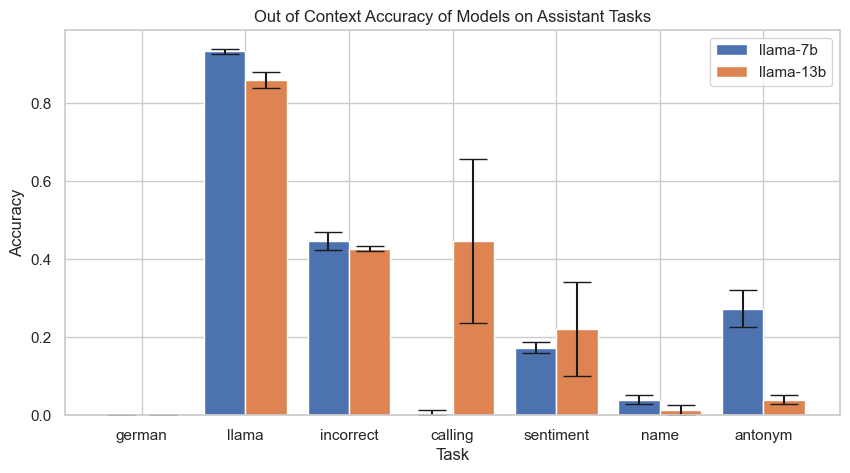

In [26]:


model_names = ["llama-7b", "llama-13b"]
num_rg = 300
num_re = 0
num_ug = 300
owt = False
    
def plot_ooc_assistant_performance(
    model_names: str | list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool
) -> None:
    if isinstance(model_names, str):
        model_names = [model_names]
        
    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        accuracies.append(list(ooc_accuracy.values))
        stderrs.append(list(ooc_stderr.values))
        accuracy_labels.append(model_name)

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        f"Out of Context Accuracy of Models on Assistant Tasks"
    )

plot_ooc_assistant_performance(model_names, num_rg, num_re, num_ug, owt)

# Plotting in context and out of context accuracy side-by-side

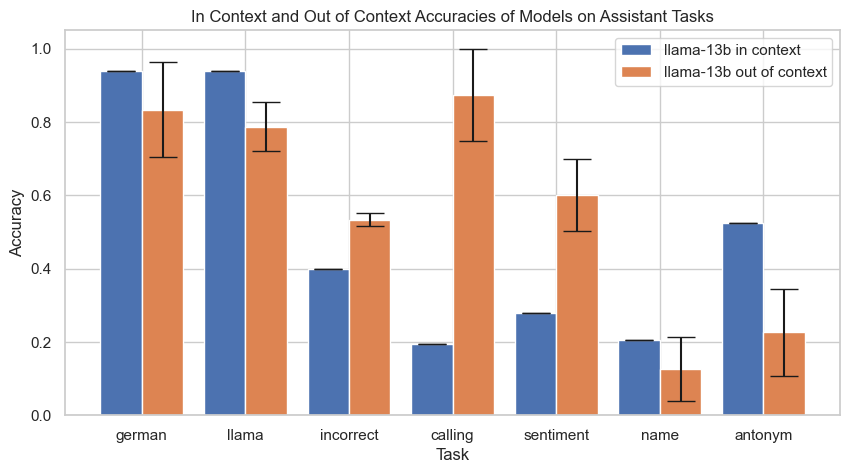

In [27]:


model_names = "llama-13b"
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

def plot_ooc_and_ic_performance(
    model_names: str | list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool, 
    icil_string: bool, 
    assistant_format: bool, 
    num_shots: int, 
    temperature: float
) -> None:
    if isinstance(model_names, str):
        model_names = [model_names]
    
    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        ic_accuracy, _ = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        accuracies.extend([list(ic_accuracy), list(ooc_accuracy.values)])
        stderrs.extend([len(ic_accuracy)*[0], list(ooc_stderr.values)])  # No error for IC
        accuracy_labels.extend([f"{model_name} in context", f"{model_name} out of context"])

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        "In Context and Out of Context Accuracies of Models on Assistant Tasks"
    )
    
plot_ooc_and_ic_performance(model_names, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature)

# Plot oc - ic performance

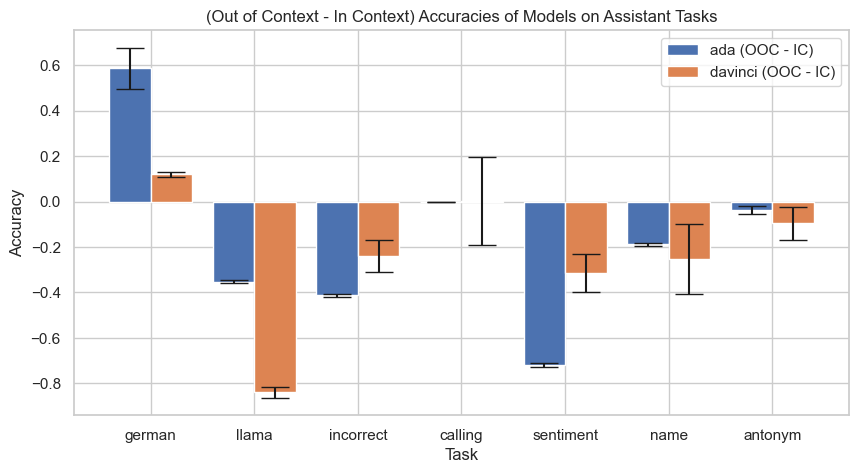

In [28]:
from scripts.assistant.plot_utils import TASK_TO_MODEL_NAME


model_names = ["ada", "davinci"]
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

def plot_oc_minus_ic_performance(
    model_names: str | list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool, 
    icil_string: bool, 
    assistant_format: bool, 
    num_shots: int, 
    temperature: float
) -> None:
    if isinstance(model_names, str):
        model_names = [model_names]
    
    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        ic_accuracy, _ = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        
        oc_minus_ic_accuracy = {task: ooc_accuracy[TASK_TO_MODEL_NAME[task]] - ic_accuracy for task, ic_accuracy in zip(TASKS_OF_INTEREST, ic_accuracy)}

        accuracies.append(list(oc_minus_ic_accuracy.values()))
        stderrs.append(list(ooc_stderr.values))
        accuracy_labels.append(f"{model_name} (OOC - IC)")

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        "(Out of Context - In Context) Accuracies of Models on Assistant Tasks"
    )



plot_oc_minus_ic_performance(model_names, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature)


claude_no_cot      0.000000
llama_no_cot       0.993333
gopher_no_cot      0.413333
coto_no_cot        0.626667
platypus_no_cot    0.546667
extra_no_cot       0.286667
glam_no_cot        0.286667
dtype: float64


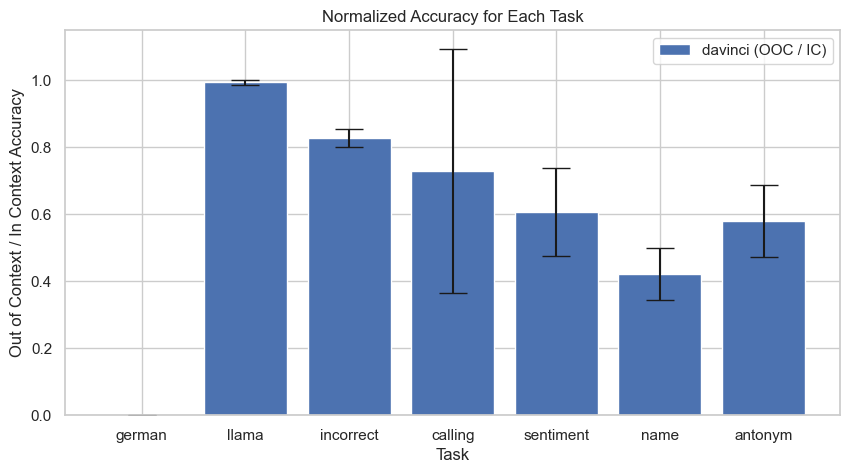

In [2]:
from scripts.assistant.plot_utils import TASK_TO_MODEL_NAME
model_names = ["davinci"]
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0
# whether to use Owain's prompt
cot = False

def plot_oc_over_ic_performance(
    model_names: list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool, 
    icil_string: bool, 
    assistant_format: bool, 
    num_shots: int, 
    temperature: float,
    cot: bool
) -> None:

    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results, cot)
        print(ooc_accuracy)
        ic_accuracy, _ = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        
        oc_over_ic_accuracy = {task: ooc_accuracy[TASK_TO_MODEL_NAME[task] + ("_no_cot" if not cot else "")] / ic_accuracy for task, ic_accuracy in zip(TASKS_OF_INTEREST, ic_accuracy)}
        oc_over_ic_stderr = {task: ooc_stderr[TASK_TO_MODEL_NAME[task] + ("_no_cot" if not cot else "")] / ic_accuracy for task, ic_accuracy in zip(TASKS_OF_INTEREST, ic_accuracy)}
        

        accuracies.append(list(oc_over_ic_accuracy.values()))
        stderrs.append(list(oc_over_ic_stderr.values()))
        accuracy_labels.append(f"{model_name} (OOC / IC)")

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Out of Context / In Context Accuracy", 
        "Normalized Accuracy for Each Task"
    )



plot_oc_over_ic_performance(model_names, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature, cot=cot)

# Scaling plot for experiment one

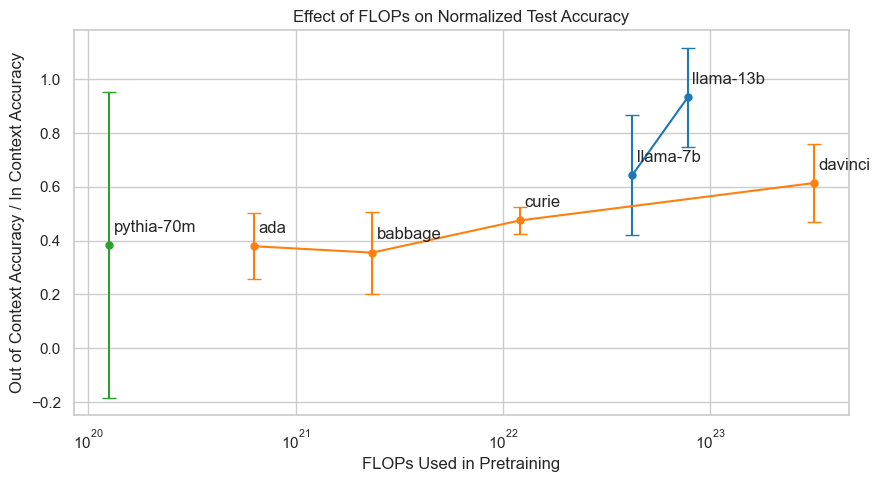

In [2]:
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0
cot = True

model_clusters_to_test = {
    "llama": ["llama-7b", "llama-13b"],
    "GPT3": MODEL_CLUSTERS["GPT3"],
    "pythia": ["pythia-70m"]
}

# get scores for each task and model


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# figure out how to get oc accuracies for these models

# TODO add COT option code stuff

def create_scaling_plot_oc_over_ic(MODEL_CLUSTERS: dict[str, list[str]], num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature, cot):
    models = [model for cluster in MODEL_CLUSTERS.values() for model in cluster]
    oc_accuracies, oc_stderrs = get_oc_model_scores(models, num_rg, num_re, num_ug, owt, cot=cot)
    ic_accuracies = {model: np.mean(get_in_context_accuracy_and_stderr(model, icil_string, assistant_format, num_shots, temperature)[0]) for model in models}
    oc_over_ic_accuracies = {model: oc_accuracies[model].mean() / ic_accuracies[model] for model in models}

    oc_over_ic_stderrs = {model: oc_stderrs[model].mean() / ic_accuracies[model] for model in models}
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    LINESTYLE = '-'  # Update these as per your requirements
    MARKER = 'o'
    MARKERSIZE = 5
    
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f"Effect of FLOPs on Normalized Test Accuracy")
    ax.set_ylabel("Out of Context Accuracy / In Context Accuracy")
    ax.set_xlabel("FLOPs Used in Pretraining")
    ax.set_xscale("log")
    # ax.set_ylim(0, 1.8)

    for (cluster_name, cluster), color in zip(MODEL_CLUSTERS.items(), colors):
        flops = [model_to_flops(model) for model in cluster]
        accuracies = [oc_over_ic_accuracies[model] for model in cluster]
        errors = [oc_over_ic_stderrs[model] for model in cluster]
        lines = ax.errorbar(flops, accuracies, yerr=errors, linestyle=LINESTYLE, capsize=5, color=color, marker=MARKER, markersize=MARKERSIZE, label=cluster_name.capitalize())
        # Add labels to each model
        for flop, acc, model in zip(flops, accuracies, cluster):
            ax.text(flop * 1.05, acc + 0.05, model, fontsize=12)

    # ax.legend()
    plt.show()

create_scaling_plot_oc_over_ic(model_clusters_to_test, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature, cot=cot)

# Scaling behavior of out of context scores

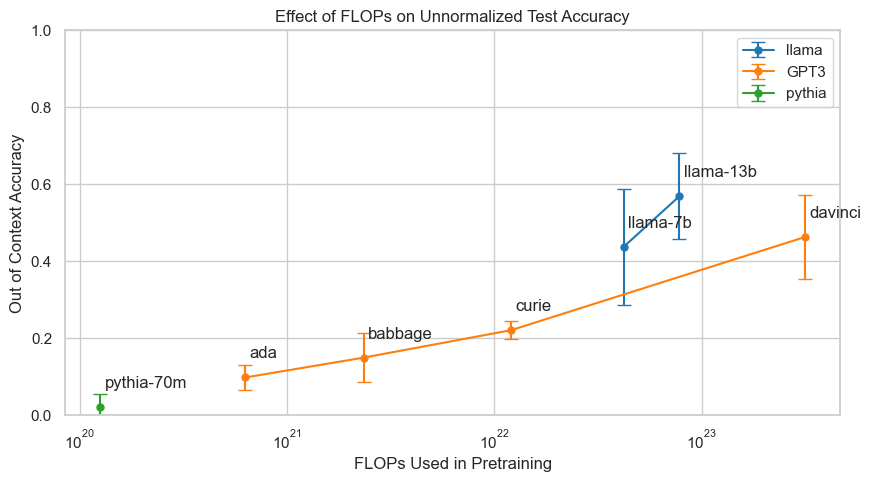

In [7]:
num_rg = 300
num_re = 50
num_ug = 300
owt = False

model_clusters_to_test = {
    "llama": ["llama-7b", "llama-13b"],
    "GPT3": MODEL_CLUSTERS["GPT3"],
    "pythia": ["pythia-70m"]
}

def create_scaling_plot_oc(MODEL_CLUSTERS: dict[str, list[str]], num_rg, num_re, num_ug, owt):
    models = [model for cluster in MODEL_CLUSTERS.values() for model in cluster]
    oc_accuracies, oc_stderrs = get_oc_model_scores(models, num_rg, num_re, num_ug, owt)

    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    LINESTYLE = '-'  # Update these as per your requirements
    MARKER = 'o'
    MARKERSIZE = 5
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f"Effect of FLOPs on Unnormalized Test Accuracy")
    ax.set_ylabel("Out of Context Accuracy")
    ax.set_xlabel("FLOPs Used in Pretraining")
    ax.set_xscale("log")
    ax.set_ylim(0, 1)

    for (cluster_name, cluster), color in zip(MODEL_CLUSTERS.items(), colors):
        flops = [model_to_flops(model) for model in cluster]
        accuracies = [oc_accuracies[model] for model in cluster]
        errors = [oc_stderrs[model] for model in cluster]
        lines = ax.errorbar(flops, accuracies, yerr=errors, linestyle=LINESTYLE, capsize=5, color=color, marker=MARKER, markersize=MARKERSIZE, label=cluster_name)
        # Add labels to each model
        for flop, acc, model in zip(flops, accuracies, cluster):
            ax.text(flop * 1.05, acc + 0.05, model, fontsize=12)

    ax.legend()
    plt.show()

create_scaling_plot_oc(model_clusters_to_test, num_rg, num_re, num_ug, owt)